In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from PIL import Image

In [2]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

In [3]:
# Assumption image is 80px by 80px => 6400 variables
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 100*u.uas.to(u.rad)): #Ask about u.rad
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)

    for i in range(len(data_list)):
        vis_data = data_list[i].amp * np.exp(1j * math.radians(data_list[i].phase))
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data) / data_list[i].sigma) ** 2
        error_sum += error
    
    return error_sum + reg_weight * calc_regularizer(image=image, tsv=True, p=2)

In [4]:
# Assumption image_shift_half is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image_shift_half, coords, FOV):
    ft_image = np.fft.fftshift(np.fft.fft2(image_shift_half)) # Investigate to make sure what this fft does

    #kx_1 = 2*math.pi/FOV
    kx_1 = 1/FOV
    # kx_1 is 1/coeff

    kx = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[0])//2 - 1, ft_image.shape[0]) * kx_1
    ky = np.linspace(ft_image.shape[0]//-2, (ft_image.shape[1])//2 - 1, ft_image.shape[1]) * kx_1
    
    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)
    #print(imag)
    return real + imag * 1j

In [5]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = 0
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = 0

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))
    return reg

In [6]:
def process_data(data_df):
    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [7]:
def read_data(filename: str()):
    df = pd.read_csv(filename)
    return df

Loads Image and data

In [8]:
df = read_data("./data/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv")
coords, data_list = process_data(df)
file = open("images/3597_blur_avg.txt","r")
lines = file.readlines()
image_shift_half = np.empty([180,180])
image = np.empty([180,180])
t = []
for line in lines:
    coord = line.strip().split()
    x = int(float(coord[0]) * 1000000)
    y = int(float(coord[1]) * 1000000)
    z = int(float(coord[2]) * 10000000000)
    image_shift_half[x][y] = z
    image[x+90][y+90] = z

(-0.5, 179.5, 179.5, -0.5)

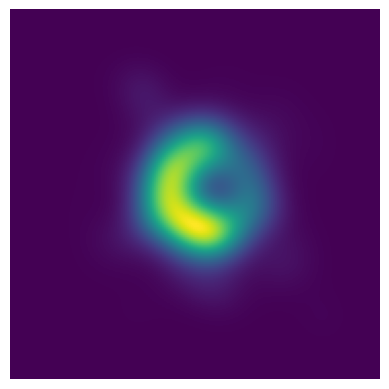

In [9]:
plt.figure()
plt.imshow(image)
plt.axis('off')

(-0.5, 179.5, 179.5, -0.5)

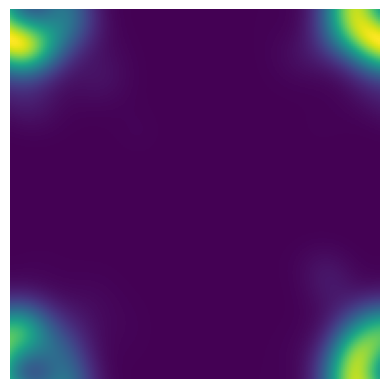

In [10]:
plt.figure()
plt.imshow(image_shift_half)
plt.axis('off')

In [11]:
print(loss(image, data_list, coords, p = 2, reg_weight = 0))

4.0331129981971364e+26


In [12]:
loss_arr = np.zeros((len(image),len(image[0])))
for i in range(len(image)):
    image_1 = np.roll(image, i, axis=1)
    for j in range(len(image[i])):
        image_2 = np.roll(image_1, j, axis = 0)
        loss_arr[i][j] = loss(image_2, data_list, coords, reg_weight=0)

In [13]:
np.min(loss_arr)

4.015861780619055e+26

In [14]:
np.max(loss_arr)

1.1508710253123274e+27

In [15]:
np.unravel_index(np.argmin(loss_arr, axis=None), loss_arr.shape)

(3, 174)

(-0.5, 179.5, 179.5, -0.5)

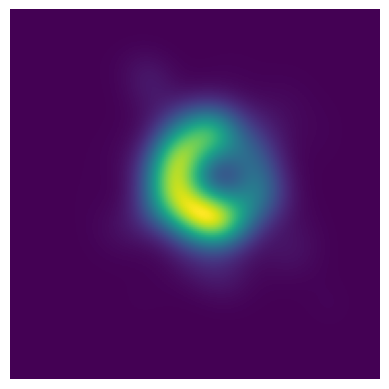

In [16]:
shift = np.roll(image, 3, axis=1)
shift = np.roll(shift, 174, axis = 0)
plt.figure()
plt.imshow(shift)
plt.axis('off')

In [47]:
loss((12e-11)*image,data_list,coords,reg_weight=0)

18944738.69808496

In [57]:
losses_list = []
amps = []
for i in range(-100,200):
    amp = (i/10)*1e-11
    amps.append(amp)
    losses_list.append(loss(amp*image,data_list,coords,reg_weight=0))

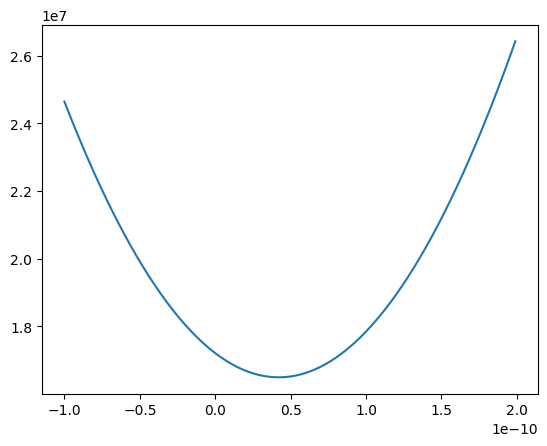

In [58]:
plt.plot(amps,losses_list)

In [60]:
losses_list[np.argmin(losses_list)]

16498254.403093431